In [1]:
# Install and import necessary packages

!pip install -U numpy control multiprocess tqdm jupyterlab_widgets ipywidgets

import numpy as np
import control as ct
import cmath
import math
import os
from tqdm.notebook import tqdm
from multiprocess import Pool

## Transfer Functions

As per Bruno Putzey's 2011 paper titled ["Global Modulated Self-Oscillating Amplifier with Improved Linearity"](https://www.hypex.nl/media/3f/62/4a/1682342035/Globally%20modulated%20self-oscillating%20amplifier.pdf), we treat our Class-D amplifier as a square wave oscillator wrapped with a linear function. For simplicity's sake, we further split said linear function into three serial sections–the **propagation delay**, **low pass filter**, and **feedback network**. Using the *python-control* library, we algebraically define each based on component values. Please modify the below functions to suit your needs.

In [2]:
def delay(td) -> ct.TransferFunction:
    s = ct.tf('s')
    
    return ct.TransferFunction(*ct.pade(td, n=20))

def lpf(L, C, R_load) -> ct.TransferFunction:
    s = ct.tf('s')
    
    return R_load / (R_load * L * C * s**2 + L * s + R_load)

def fbn(R_in, R_fb, R_lead, C_lead, C_int, R1_int, R2_int, R_int) -> ct.TransferFunction:
    s = ct.tf('s')
    
    a = R1_int * R2_int * C_int * R_int * C_lead  * (R_in + R_fb)
    b = R2_int * ((R1_int * C_int * R_in * R_lead) + (R_in * R_int * C_lead) + (R_fb * R_int * C_lead))
    bd = R2_int * R1_int * C_int * R_lead * R_fb
    ca = (R1_int + R2_int) * R_in * R_lead
    cb = (R_in + R_fb) * R2_int * R_lead

    return (a * s**2 + b * s + ca)/(a * s**2 + (b + bd) * s + cb)

In [110]:
def calc_fresp(H: ct.TransferFunction, H_prop: float, h: float, omega):
    """ Calculates the frequency response of a given linear wrapper
    function given a duty cycle 'h'.
    """

    def inf_sum(f):
        sum = 0        
        for n in range(1, 5000):
            
            sum += (
                H(2j * cmath.pi * f * n) * 
                cmath.exp((-H_prop) * 2j * cmath.pi * f) * 
                (1 - cmath.exp((-2j) * cmath.pi * n * h)) * 
                (1 - cmath.exp(2j * cmath.pi * n * h)) / (2 * n))
            
    
        return sum
    
    with Pool(os.cpu_count()) as p:
        res = list(tqdm(p.imap(inf_sum, omega / (2 * np.pi)), total=len(omega)))

    return ct.FrequencyResponseData(res, omega, smooth=True)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

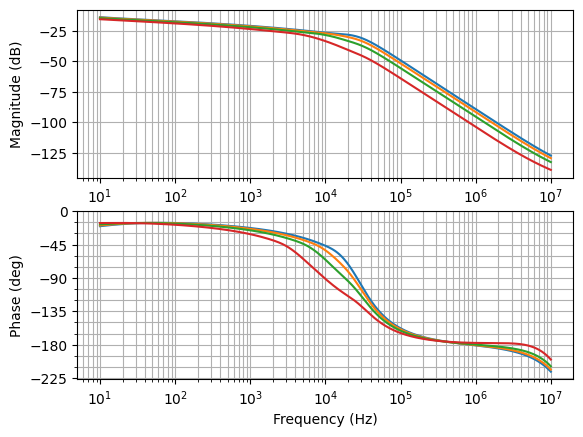

In [111]:
omega = 2 * np.pi * np.logspace(1, 7, num=1000)

_ = ct.bode_plot([calc_fresp(
    lpf(33e-6, 1e-6, 4) *
    fbn(2.2e3, 100e3, 220, 2.2e-12, 100e-9, 1e6, 220e3, 22e3),
    20e-9, i/10, omega) for i in [5, 3, 2, 1]], omega, dB=True, Hz=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

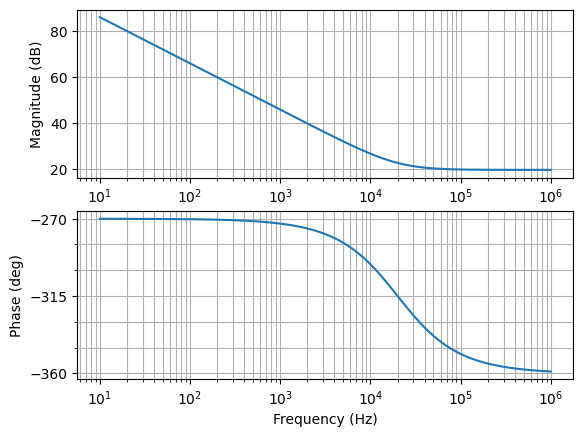

In [107]:
omega = 2 * np.pi * np.logspace(1, 6, num=1000)
s = ct.tf('s')

_ = ct.bode_plot(calc_fresp(
    1 - (10 ** 6 / s), 1e-10,
    0.5, omega), omega, dB=True, Hz=True)